<a href="https://colab.research.google.com/github/mssuhas/IIIT-training/blob/main/ML_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10 # to download the CIFAR10 dataset
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Dataset
Prepare the dataset for the training and validation of the model

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5, 0.5))])

In [ ]:

batch_size = 8

trainset = CIFAR10(root="./dataset", transform=transform, train=True,download=True)
testset = CIFAR10(root="./dataset", transform=transform, train=False, download=True)
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=1)

train_dataset_size = len(trainloader)
test_dataset_size = len(testloader)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


## 2. Visualize the data

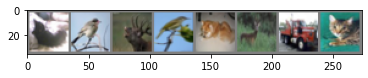

  cat  bird  deer  bird   dog  deer truck   cat


In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 3. Define the model

In [ ]:
# defining nn model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #define the layers
        self.fc1 = nn.Linear(3*32*32,1024*4)
        self.fc2 = nn.Linear(1024*4, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 128)
        self.fc6 = nn.Linear(128, 32)
        self.fc7 = nn.Linear(32, 10) # --> no. of class
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x): # create the computation graph
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x) 
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        
        return x

In [ ]:
net = Model().cuda()

In [ ]:
summary(net, (1, 3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]      12,587,008
              ReLU-2              [-1, 1, 4096]               0
            Linear-3              [-1, 1, 1024]       4,195,328
              ReLU-4              [-1, 1, 1024]               0
            Linear-5              [-1, 1, 1024]       1,049,600
              ReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 512]         524,800
              ReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 128]          65,664
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 32]           4,128
             ReLU-12                [-1, 1, 32]               0
           Linear-13                [-1, 1, 10]             330
Total params: 18,426,858
Trainable para

## 4. Define hyper-parameters and loss functions

In [ ]:
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

epochs = 20

## 5. Train & Evaluate the model

In [ ]:
def train_validation_accuracy(train, val):
    x=np.arange(epochs)
    plt.figure(figsize=(10,10))
    plt.title("Accuracy vs Epoch")
    plt.plot(x, train, label="Train Accuracy")
    plt.plot(x,val, label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    

In [ ]:
net.zero_grad()

accuracy_train = []
accuracy_val = []

for each_epoch in range(epochs):
    print("\nEpoch {}".format(each_epoch+1))
    print("-"*20)
    running_losses = 0
    running_corrects = 0
    
    for data, target in trainloader:
        optimizer.zero_grad()
        d,t = data.view(batch_size,-1).cuda(), target.cuda()
        output = net(d)
        loss = criterion(output,t)
        
        _,preds = torch.max(output,1)
        
        running_losses += loss.data.item()*data.size(0)
        running_corrects += torch.sum(preds == t.data)/float(data.size(0))
        
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_losses / train_dataset_size
    epoch_acc = running_corrects / train_dataset_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("TRAIN", epoch_loss, epoch_acc))
    
    accuracy_train.append(epoch_acc)
    
    val_losses = 0.0
    val_corrects = 0.0
    with torch.no_grad():
        for data, target in testloader:
            d, t = data.view(data.size(0),-1).cuda(), target.cuda()
            output = net(d)
            loss = criterion(output, t)
            
            _, preds = torch.max(output, 1)
            val_losses += loss.data.item()*data.size(0)
            val_corrects += torch.sum(preds == t.data)/float(data.size(0))
            
        val_epoch_loss = val_losses / test_dataset_size
        val_epoch_acc = val_corrects / test_dataset_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format("VAL", val_epoch_loss, val_epoch_acc))
        
        accuracy_val.append(val_epoch_acc)
    
print("Finished")

train_validation_accuracy(np.array(accuracy_train), np.array(accuracy_val))


Epoch 1
--------------------
TRAIN Loss: 0.3982 Acc: 0.9836
VAL Loss: 25.5298 Acc: 0.5615

Epoch 2
--------------------
TRAIN Loss: 0.4084 Acc: 0.9829
VAL Loss: 24.0523 Acc: 0.5680

Epoch 3
--------------------
TRAIN Loss: 0.3254 Acc: 0.9868
VAL Loss: 25.4132 Acc: 0.5697

Epoch 4
--------------------
TRAIN Loss: 0.3322 Acc: 0.9866
VAL Loss: 26.0533 Acc: 0.5677

Epoch 5
--------------------
TRAIN Loss: 0.3371 Acc: 0.9860
VAL Loss: 24.7729 Acc: 0.5700

Epoch 6
--------------------
TRAIN Loss: 0.2488 Acc: 0.9898
VAL Loss: 26.2416 Acc: 0.5720

Epoch 7
--------------------
TRAIN Loss: 0.2310 Acc: 0.9908
VAL Loss: 26.6060 Acc: 0.5713

Epoch 8
--------------------
TRAIN Loss: 0.1907 Acc: 0.9931
VAL Loss: 27.7956 Acc: 0.5726

Epoch 9
--------------------
